**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---


In [76]:
# Import helpful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from xgboost import XGBRegressor

# Load the data, and separate the target
train_file_path = '../input/train.csv'
test_data_path = '../input/test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_data_path)
Y = train_data.SalePrice
train_data.drop(columns=['SalePrice'],axis=1,inplace=True)

warnings.simplefilter('ignore')
pd.set_option('display.max_rows',None)

Here's some of the code you've written so far. Start by running it again.

In [ ]:
# Import helpful libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load the data, and separate the target
iowa_file_path = '../input/train.csv'
home_data = pd.read_csv(iowa_file_path)
y = home_data.SalePrice

# Create X (After completing the exercise, you can return to modify this line!)
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']

# Select columns corresponding to features, and preview the data
X = home_data[features]
X.head()

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

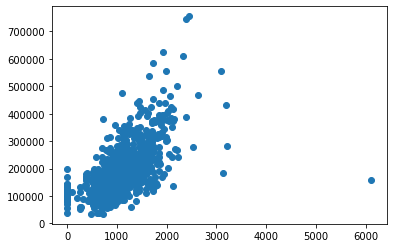

In [77]:
plt.scatter(train_data.TotalBsmtSF,Y)
outliers=((train_data['GrLivArea']>4000) & (Y<300000))|((train_data['OverallCond']==2) & (Y>300000))
train_data.drop(train_data[outliers].index,inplace=True)
Y.drop(Y[outliers].index,inplace=True)

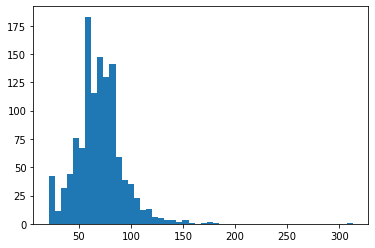

In [78]:
plt.hist(train_data.LotFrontage,bins=50)
plt.show()
train_data['LotArea']=train_data.LotArea.apply(np.log1p)
test_data['LotArea']=test_data.LotArea.apply(np.log1p)
train_data['LotFrontage']=train_data.LotFrontage.apply(np.log1p)
test_data['LotFrontage']=test_data.LotFrontage.apply(np.log1p)

In [79]:
numerical=['LotFrontage', 'BsmtFinSF1', 'WoodDeckSF', 'MSSubClass', '2ndFlrSF', 'TotRmsAbvGrd', 'MasVnrArea', 'YearRemodAdd', 'ScreenPorch', 'OverallCond', 'EnclosedPorch', 'GrLivArea', 'GarageArea', 'LowQualFinSF', 'OverallQual', 'TotalBsmtSF', 'KitchenAbvGr', 'GarageYrBlt', 'BedroomAbvGr', '1stFlrSF', 'YearBuilt', 'OpenPorchSF', 'LotArea', 'BsmtUnfSF']
most_frequent_imp_cat=['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'YrSold', 'Fireplaces']
constant_imp_cat=['PoolQC','Alley','Fence']
categorical=most_frequent_imp_cat+constant_imp_cat

In [80]:
print(train_data.isnull().sum().sort_values(ascending=False))
num_imp=SimpleImputer(strategy='median')
cat_imp=SimpleImputer(strategy='most_frequent')
train_data[numerical]=num_imp.fit_transform(train_data[numerical])
train_data[categorical]=cat_imp.fit_transform(train_data[categorical])

PoolQC           1451
MiscFeature      1403
Alley            1366
Fence            1176
FireplaceQu       690
LotFrontage       259
GarageType         81
GarageYrBlt        81
GarageQual         81
GarageCond         81
GarageFinish       81
BsmtFinType2       38
BsmtExposure       38
BsmtCond           37
BsmtFinType1       37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
HalfBath            0
BsmtFullBath        0
BsmtHalfBath        0
BedroomAbvGr        0
FullBath            0
TotRmsAbvGrd        0
Functional          0
KitchenAbvGr        0
KitchenQual         0
Id                  0
Fireplaces          0
LowQualFinSF        0
GarageCars          0
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
GrLivArea           0
HeatingQC 

In [81]:
def get_score(pipeline,cv,X,y):
    return -1*cross_val_score(pipeline,X,y,cv=cv,scoring='neg_mean_absolute_error').mean()

def mi_scores(X, y,discrete):
    if(discrete):
        mi_scores = mutual_info_regression(X, y, random_state=0,discrete_features=X.dtypes==int)
    else:
        mi_scores=mutual_info_regression(X,y,random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
def plot_mi_scores(scores,feature_type):
    scores=scores.sort_values(ascending=True)
    plt.barh(scores.index,scores)
    plt.title('Mutual Information Scores '+feature_type+ ' variables')

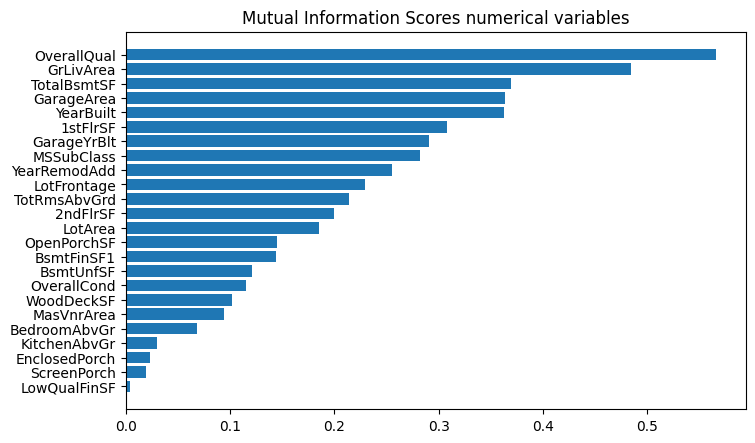

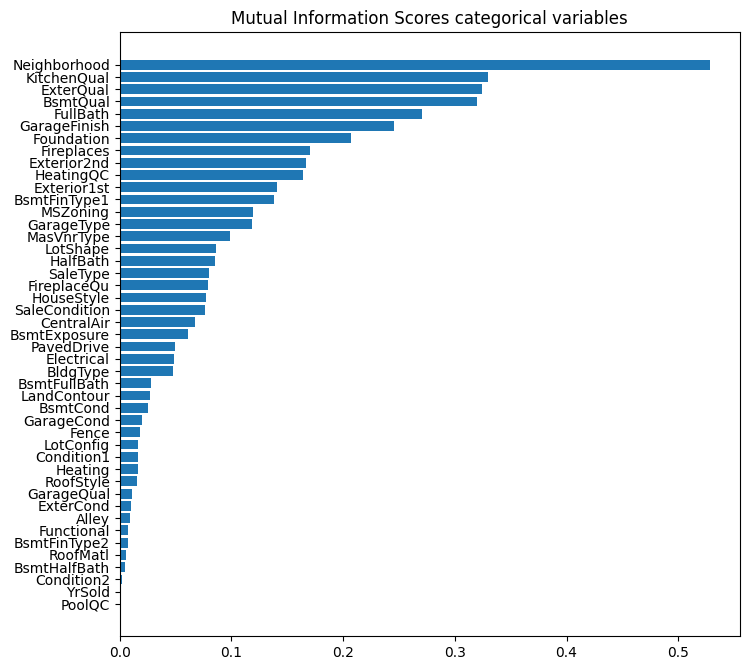

In [82]:
X=train_data[categorical].copy()
for col in categorical:
    X[col],_=X[col].factorize()
categorical=X.dtypes==int
scores=mi_scores(train_data[numerical],Y,discrete=False)
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(scores,'numerical')
plt.show()


plt.figure(dpi=100,figsize=(8,8))
scores=mi_scores(X,Y,discrete=True)
plot_mi_scores(scores,'categorical')
plt.show()

In [83]:
X_train=train_data[constant_imp_cat+most_frequent_imp_cat+numerical]
X_test=test_data[constant_imp_cat+most_frequent_imp_cat+numerical]

In [89]:
numtr=SimpleImputer(strategy='median')
cattr=Pipeline(steps=[('Imputer',SimpleImputer(strategy='most_frequent')),('OHE',OneHotEncoder(handle_unknown='ignore',sparse=False))])
contr=Pipeline(steps=[('Imputer',SimpleImputer(strategy='constant',fill_value='NA')),('OHE',OneHotEncoder(handle_unknown='ignore',sparse=False))])
prepr=ColumnTransformer(transformers=[('num',numtr,numerical),('cons',contr,constant_imp_cat),('cat',cattr,most_frequent_imp_cat)])
#xgb=XGBRegressor(n_estimators=6000,learning_rate=0.01,random_state=0)
gb=GradientBoostingRegressor(n_estimators=6000,learning_rate=0.03,max_depth=2)
model=Pipeline(steps=[('preprocessor',prepr),('model',gb)])

In [ ]:
'''
numtr=SimpleImputer(strategy='median')
cattr=Pipeline(steps=[('Imputer',SimpleImputer(strategy='most_frequent')),('OHE',OneHotEncoder(handle_unknown='ignore',sparse=False))])
prepr=ColumnTransformer(transformers=[('num',numtr,numerical),('cat',cattr,categorical)])
gb=GradientBoostingRegressor()
model=Pipeline(steps=[('preprocessor',prepr),('model',gb)])
param_grid = {'model__n_estimators': [5000,6000,7000,8000],'model__learning_rate': [0.01,0.02,0.03,0.04,0.05],
    'model__max_depth':[1,2,3,4]}
gridsearch=GridSearchCV(model,param_grid,n_jobs=4)
gridsearch.fit(X_train,Y)

'''

In [ ]:
#score=get_score(model,5,X_train,Y)
#print("Score:{}".format(score))
model.fit(X_train,Y)
#print(gridsearch.best_params_)
#test_preds=gridsearch.best_estimator_.predict(X_test)
test_preds=model.predict(X_test)


In [87]:
rf_val_mae = mean_absolute_error(Y, test_preds[:-2])
print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))

Validation MAE for Random Forest Model: 81,304


# Generate a submission

Run the code cell below to generate a CSV file with your predictions that you can use to submit to the competition.

In [90]:
# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/__init__.py", line 416, in _get_column_indices
    idx = _safe_indexing(np.arange(n_columns), key)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/__init__.py", line 395, in _safe_indexing
    return _array_indexing(X, indices, indices_dtype, axis=axis)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/__init__.py", line 181, in _array_indexing
    return array[key] if axis == 0 else array[:, key]
IndexError: boolean index did not match indexed array along dimension 0; dimension is 69 but corresponding boolean dimension is 45

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/conda/lib/python

# Submit to the competition

To test your results, you'll need to join the competition (if you haven't already).  So open a new window by clicking on **[this link](https://www.kaggle.com/c/home-data-for-ml-course)**.  Then click on the **Join Competition** button.

![join competition image](https://i.imgur.com/axBzctl.png)

Next, follow the instructions below:
1. Begin by clicking on the **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Continue Your Progress
There are many ways to improve your model, and **experimenting is a great way to learn at this point.**

The best way to improve your model is to add features.  To add more features to the data, revisit the first code cell, and change this line of code to include more column names:
```python
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
```

Some features will cause errors because of issues like missing values or non-numeric data types.  Here is a complete list of potential columns that you might like to use, and that won't throw errors:
- 'MSSubClass'
- 'LotArea'
- 'OverallQual' 
- 'OverallCond' 
- 'YearBuilt'
- 'YearRemodAdd' 
- '1stFlrSF'
- '2ndFlrSF' 
- 'LowQualFinSF' 
- 'GrLivArea'
- 'FullBath'
- 'HalfBath'
- 'BedroomAbvGr' 
- 'KitchenAbvGr' 
- 'TotRmsAbvGrd' 
- 'Fireplaces' 
- 'WoodDeckSF' 
- 'OpenPorchSF'
- 'EnclosedPorch' 
- '3SsnPorch' 
- 'ScreenPorch' 
- 'PoolArea' 
- 'MiscVal' 
- 'MoSold' 
- 'YrSold'

Look at the list of columns and think about what might affect home prices.  To learn more about each of these features, take a look at the data description on the **[competition page](https://www.kaggle.com/c/home-data-for-ml-course/data)**.

After updating the code cell above that defines the features, re-run all of the code cells to evaluate the model and generate a new submission file.  


# What's next?

As mentioned above, some of the features will throw an error if you try to use them to train your model.  The **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course will teach you how to handle these types of features. You will also learn to use **xgboost**, a technique giving even better accuracy than Random Forest.

The **[Pandas](https://kaggle.com/Learn/Pandas)** course will give you the data manipulation skills to quickly go from conceptual idea to implementation in your data science projects. 

You are also ready for the **[Deep Learning](https://kaggle.com/Learn/intro-to-Deep-Learning)** course, where you will build models with better-than-human level performance at computer vision tasks.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-machine-learning/discussion) to chat with other learners.*